In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cophenet
import spacy
import json
import numpy as np
import pandas as pd
import re
import string
import multiprocessing
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
import joblib
from joblib import Parallel, delayed
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
save_json_file_path = '/Users/cpan/OneDrive - Guardant Health/clean_test_results/labeled_test_results.json'

In [3]:
def preprocess_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove dates
    text = re.sub(r'\d{1,2}\/\d{1,2}\/\d{4}', '', text)

    # Remove special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    return text

def custom_tokenizer(text):
    tokens = text.split()  # Split text into tokens
    filtered_tokens = [token for token in tokens if len(token) > 2]  # Exclude tokens with one element
    return filtered_tokens

In [5]:
vectorizer = joblib.load('vectorizer_kmeans.pkl')

In [6]:
data_vectorized = joblib.load('data_vectorized_kmeans.pkl')

In [15]:
# turn into dense data vectors 
data_vectorized_dense= data_vectorized.toarray()

In [7]:
with open(save_json_file_path, "r") as f:
    data = json.load(f)

In [8]:
# load page content with file names 
all_pages_with_filenames = joblib.load('all_pages_with_filenames.pkl')
all_page_content = joblib.load("all_page_content.pkl")

In [19]:
# all_pages_with_filenames[:2]

In [21]:
# all_page_content[0]

hyperparameters to tune:
- number of clusters: 2~ 16 
- linkage
- affinity
- distance

In [11]:
def find_optimal_clusters_hierarchical(data, max_clusters, linkage_method):
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        agglomerative = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
        cluster_labels = agglomerative.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append((k, silhouette_avg))
    
    return silhouette_scores

In [12]:
linkage_methods = ['ward', 'complete', 'average']

In [19]:
best_silhouette_score = -1
best_num_clusters = -1
best_linkage_method = ''
results = Parallel(n_jobs=-1)(
    delayed(find_optimal_clusters_hierarchical)(data_vectorized_dense, max_clusters=16, linkage_method=method)
    for method in linkage_methods
)

for linkage_result, linkage_method in zip(results, linkage_methods):
    for num_clusters, silhouette_avg in linkage_result:
        print(f"For {num_clusters} clusters using linkage '{linkage_method}', silhouette score: {silhouette_avg:.4f}")
        
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_num_clusters = num_clusters
            best_linkage_method = linkage_method

print(f"Best silhouette score: {best_silhouette_score:.4f}")
print(f"Optimized number of clusters: {best_num_clusters}")
print(f"Best linkage method: {best_linkage_method}")

For 2 clusters using linkage 'ward', silhouette score: 0.0186
For 3 clusters using linkage 'ward', silhouette score: 0.0273
For 4 clusters using linkage 'ward', silhouette score: 0.0279
For 5 clusters using linkage 'ward', silhouette score: 0.0277
For 6 clusters using linkage 'ward', silhouette score: 0.0376
For 7 clusters using linkage 'ward', silhouette score: 0.0426
For 8 clusters using linkage 'ward', silhouette score: 0.0482
For 9 clusters using linkage 'ward', silhouette score: 0.0497
For 10 clusters using linkage 'ward', silhouette score: 0.0530
For 11 clusters using linkage 'ward', silhouette score: 0.0542
For 12 clusters using linkage 'ward', silhouette score: 0.0582
For 13 clusters using linkage 'ward', silhouette score: 0.0613
For 14 clusters using linkage 'ward', silhouette score: 0.0640
For 15 clusters using linkage 'ward', silhouette score: 0.0664
For 16 clusters using linkage 'ward', silhouette score: 0.0687
For 2 clusters using linkage 'complete', silhouette score: 0.01

In [24]:
def fit_agglomerative_and_get_top_keywords(data, data_vectorized_dense, num_clusters, num_top_keywords=10):
    # Fit Agglomerative Clustering on the data
    agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
    clusters = agglomerative.fit_predict(data_vectorized_dense)

    # Extract cluster keywords
    # Agglomerative clustering doesn't directly provide cluster centers, so let's sort based on TF-IDF scores
    order_centroids = np.argsort(data_vectorized.toarray())[:, ::-1]
    terms = np.array(vectorizer.get_feature_names_out())

    cluster_keywords = {}
    for cluster_idx in range(num_clusters):
        top_keyword_indices = order_centroids[clusters == cluster_idx][:, :num_top_keywords]
        top_keywords = [terms[idx] for idx in top_keyword_indices.ravel()]

        cluster_keywords[cluster_idx] = top_keywords

    # Assign file names to their respective clusters
    cluster_file_names = {i: [] for i in range(num_clusters)}  # Initialize dictionary to store file names for each cluster

    for idx, (file_name, _) in enumerate(data):
        cluster_file_names[clusters[idx]].append(file_name)

    return agglomerative, clusters, cluster_keywords, cluster_file_names

In [25]:
optimal_clusters = 16

In [26]:
# Fit Agglomerative Clustering and get top keywords while keeping track of file names for each cluster
agglomerative, clusters, cluster_keywords, cluster_file_names = fit_agglomerative_and_get_top_keywords(all_pages_with_filenames, data_vectorized_dense, optimal_clusters)

In [27]:
# Save KMeans model, clusters, cluster_keywords, and cluster_file_names
joblib.dump(agglomerative, 'best_fitted_agglomerative_model.pkl')
joblib.dump(clusters, 'best_fitted_agglomerative_clusters.pkl')
joblib.dump(cluster_keywords, 'best_fitted_agglomerative_cluster_keywords.pkl')
joblib.dump(cluster_file_names, 'best_fitted_agglomerative_cluster_file_names.pkl')

['best_fitted_agglomerative_cluster_file_names.pkl']

In [62]:
pwd

'/Users/cpan/Desktop/project/notebooks'

#### Hierarchical Clustering Visualization

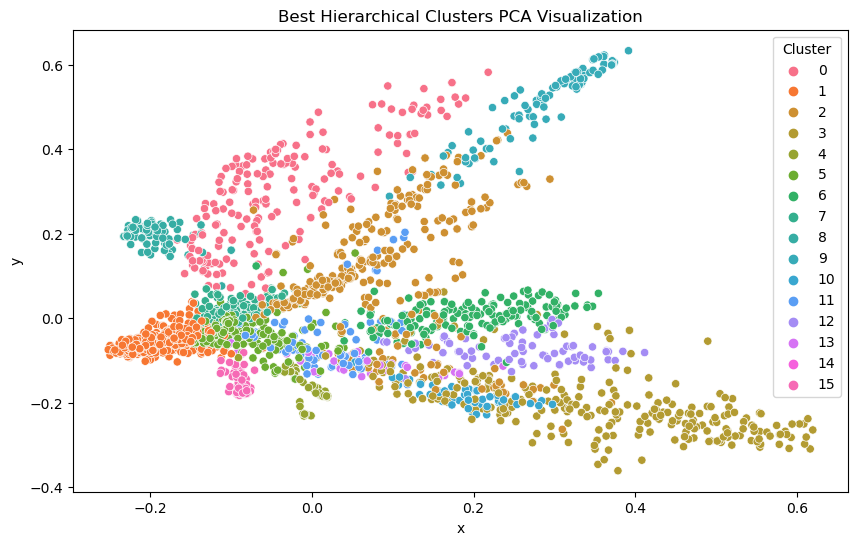

In [28]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_vectorized_dense)

# Create a DataFrame with reduced data and cluster labels
cluster_df = pd.DataFrame({'x': reduced_data[:, 0], 'y': reduced_data[:, 1], 'cluster': clusters})

# Set up a colormap
cmap = sns.color_palette("husl", n_colors=optimal_clusters)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=cluster_df, palette=cmap)
plt.title("Best Hierarchical Clusters PCA Visualization")
plt.legend(title="Cluster")
plt.show()

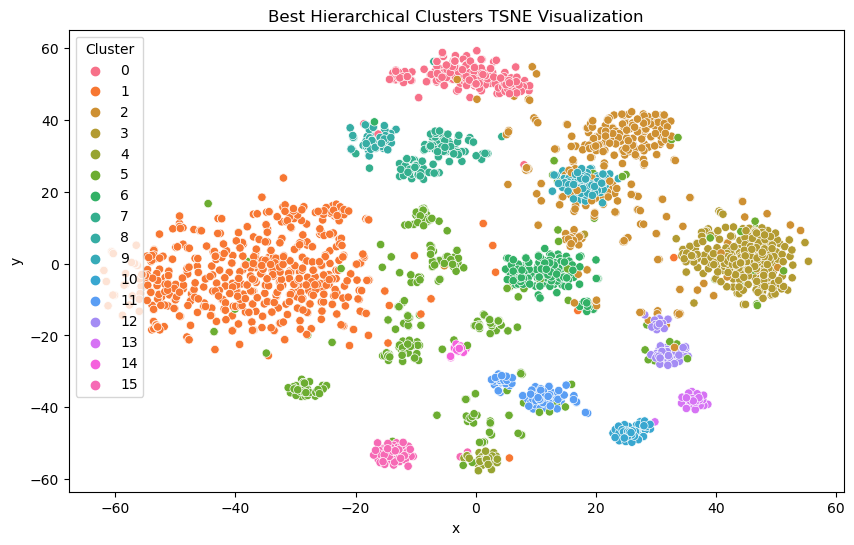

In [29]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_data = tsne.fit_transform(data_vectorized_dense)

# Create a DataFrame with reduced data and cluster labels
cluster_df2 = pd.DataFrame({'x': reduced_data[:, 0], 'y': reduced_data[:, 1], 'cluster': clusters})

# Set up a colormap
cmap = sns.color_palette("husl", n_colors=optimal_clusters)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=cluster_df2, palette=cmap)
plt.title("Best Hierarchical Clusters TSNE Visualization")
plt.legend(title="Cluster")
plt.show()

In [41]:
def create_keyword_dataframe(cluster_keywords, num_top_keywords=10):
    data = []
    for cluster_id, keywords in cluster_keywords.items():
        keywords_list = keywords[:num_top_keywords] + ['N/A'] * (num_top_keywords - len(keywords))
        data.append([cluster_id] + keywords_list)

    columns = ["Cluster"] + [f"Top Keyword {i+1}" for i in range(num_top_keywords)]
    df = pd.DataFrame(data, columns=columns)
    return df

In [42]:
keywords_df = create_keyword_dataframe(cluster_keywords)

In [43]:
keywords_df

,Cluster,Top Keyword 1,Top Keyword 2,Top Keyword 3,Top Keyword 4,Top Keyword 5,Top Keyword 6,Top Keyword 7,Top Keyword 8,Top Keyword 9,Top Keyword 10
0,0,trial,portalguardanthealthcom,carter,email,acidlitional,available,paae,ordering,title,clientservicesguardanthealthcom
1,1,interface,dispense,tablets,antoinette,regalado,childproof,fhl,refill,erx,update
2,2,clientservicesguard,confact,oliént,servicesat,annotatior,azzigcorge,anthealthcom,nameredacte,typessurgical,therapautic
3,3,map,obssived,namehok,portalquardentheatthcom,submissignampiificatione,ughest,typessurpical,arzigeorge,respdnse,amoredetaile
4,4,establish,tube,maf,cdk,germline,diagnostic,intend,plasmapositive,accordance,efficacy
5,5,authorization,holy,release,cross,heath,reports,record,court,charge,date
6,6,holy,biomarker,cross,ownerREDACTED,guerdantheaithcom,esc,blene,deétailéd,bloda,typerssurgical
7,7,gist,kit,kinase,imatinib,tyrosine,inhibitor,mutation,activation,resistREDACTEDe,resistant
8,8,phase,carcinoma,inhibitor,kit,stromal,tumor,gist,solid,gastrointestinal,target
9,9,carter,email,additional,relevance,detailed,available,portalguardanthealthcom,service,guardant,detect


potential clusters with test results keywords:
- cluster 15: biomarker, performance, evidence 
- cluster 10: gene, detect
- cluster 7: kit, inihibitor, mutation
- cluster 6: biomarker
- cluster 5: reports, record

### Find Closest Clusters

In [44]:
# Calculate pairwise distances and closest points between clusters
# straight-line distance between two points in Euclidean space. The range of distances for this metric is from 1 to infinity. 
closest_points, _ = pairwise_distances_argmin_min(agglomerative.children_, agglomerative.children_, metric='euclidean')

# Identify closest cluster pairs
closest_clusters = [(i, closest_points[i]) for i in range(len(closest_points))]

# Calculate pairwise distances between cluster centers
distances = cdist(agglomerative.children_, agglomerative.children_, metric='euclidean')

# Set diagonal elements (distance to itself) to a large value
np.fill_diagonal(distances, np.inf)

# Find indices of the closest cluster pair
row_idx, col_idx = np.unravel_index(np.argmin(distances), distances.shape)

# Get the actual distance
min_distance = distances[row_idx, col_idx]

# Get the cluster indices
closest_cluster_1 = row_idx
closest_cluster_2 = col_idx

print(f"Clusters {closest_cluster_1} and {closest_cluster_2} are closest with a distance of {min_distance:.4f}")

Clusters 0 and 14 are closest with a distance of 1.4142


but cluster 0, 14 don't seem to contain any keywords that indicate test results, but we can still include them and filter them out later 

In [56]:
print('min distance: ', np.min(distances))
print('max distance: ', np.max(distances))
flattened_distances = distances.flatten()
# Calculate the median distance
median_distance = np.median(flattened_distances)
print('median distances: ', median_distance)

min distance:  1.4142135623730951
max distance:  inf
median distances:  2393.076471824464


In [52]:
# Calculate pairwise distances between cluster centers
distances = cdist(agglomerative.children_, agglomerative.children_, metric='euclidean')

# Set diagonal elements (distance to itself) to a large value
np.fill_diagonal(distances, np.inf)

# Create a DataFrame to hold the pairwise distances
cluster_distances_df = pd.DataFrame(distances, index=range(len(distances)), columns=range(len(distances)))

In [53]:
cluster_distances_df

,0,1,2,3,4,5,6,7,8,9,...,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791
0,inf,77.781746,4.472136,13.601471,8.062258,11.401754,108.208133,3022.881572,11.401754,10.000000,...,7087.115351,7051.994682,7115.090583,7169.356526,7164.412746,7180.669676,7080.265108,7172.191924,7182.790823,7188.448094
1,77.781746,inf,82.036577,66.068147,70.035705,89.106678,185.981182,3100.663316,68.117545,87.692645,...,7164.891765,7129.776224,7192.870359,7247.138263,7242.194419,7258.451419,7158.039117,7249.973586,7260.572567,7266.229834
2,4.472136,82.036577,inf,18.027756,12.041595,7.071068,104.004808,3018.639594,15.811388,5.656854,...,7082.889806,7047.755458,7110.858317,7165.114723,7160.172205,7176.426757,7076.043103,7167.951520,7178.548043,7184.205036
3,13.601471,66.068147,18.027756,inf,9.486833,24.596748,120.283000,3034.907577,2.236068,23.259407,...,7099.063389,7064.003681,7127.068472,7181.377027,7176.427593,7192.695183,7092.197473,7184.206150,7194.815703,7200.474220
4,8.062258,70.035705,12.041595,9.486833,inf,19.104973,116.043095,3030.660984,8.062258,17.691806,...,7094.918252,7059.778042,7122.884037,7177.136058,7172.194155,7188.447538,7088.072869,7179.973538,7190.568893,7196.225747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,7180.669676,7258.451419,7176.426757,7192.695183,7188.447538,7169.355689,7072.483298,4157.788835,7190.573065,7170.769903,...,127.141653,130.000000,84.480767,12.649111,20.223748,inf,144.003472,15.297059,2.236068,7.810250
2788,7080.265108,7158.039117,7076.043103,7092.197473,7088.072869,7068.972768,6972.058591,4057.896623,7090.085754,7070.386835,...,18.384776,88.549421,60.827625,132.094663,124.064499,144.003472,inf,129.015503,145.003448,150.053324
2789,7172.191924,7249.973586,7167.951520,7184.206150,7179.973538,7160.880463,7064.001840,4149.314401,7182.085282,7162.294674,...,112.361025,120.341182,70.035705,7.615773,7.810250,15.297059,129.015503,inf,16.031220,21.095023
2790,7182.790823,7260.572567,7178.548043,7194.815703,7190.568893,7171.476975,7074.604229,4159.909735,7192.693654,7172.891188,...,128.249756,132.003788,85.708809,14.317821,21.587033,2.236068,145.003448,16.031220,inf,5.830952


In [59]:
cluster_indices_of_interest = [5, 6, 7, 10, 15, 0, 14]

# Create a new DataFrame for the selected clusters' pairwise distances
selected_distances_df = cluster_distances_df.loc[cluster_indices_of_interest, cluster_indices_of_interest]

# Display the new DataFrame
selected_distances_df

,5,6,7,10,15,0,14
5,inf,96.938125,3011.568528,82.734515,2997.427731,11.401754,11.661904
6,96.938125,inf,2914.694495,179.655225,2900.552016,108.208133,108.189648
7,3011.568528,2914.694495,inf,3094.300567,14.212670,3022.881572,3022.881572
10,82.734515,179.655225,3094.300567,inf,3080.160061,71.449283,71.505245
15,2997.427731,2900.552016,14.212670,3080.160061,inf,3008.740102,3008.739437
0,11.401754,108.208133,3022.881572,71.449283,3008.740102,inf,1.414214
14,11.661904,108.189648,3022.881572,71.505245,3008.739437,1.414214,inf


- With a distance threshold of euclidean distance of 90, the closest clusters of interest are: 
    - cluster 7, 15: 14.2
    - cluster 5, 10: 82.7
- Based on the summary of keyowrds from key clusters as the following: 

    - cluster 15: biomarker, performance, evidence
    - cluster 10: gene, detect
    - cluster 7: kit, inihibitor, mutation
    - cluster 6: biomarker, guardanthealth
    - cluster 5: reports, record
    
    - cluster 15, 6 might be potential key clusters

In [60]:
closest_key_file_names = cluster_file_names[5]+  cluster_file_names[7]+\
cluster_file_names[10] + cluster_file_names[15] + cluster_file_names[6] + cluster_file_names[0] + cluster_file_names[14]
print(len(closest_key_file_names))

973


In [61]:
path_txt =  '/Users/cpan/OneDrive - Guardant Health/page_classification_data/'
output_file_path = 'best_hierarchical_clusters_closest_key_file_names.txt'

# Write the file names to the output text file
with open(path_txt + output_file_path, 'w') as file:
    for file_name in closest_key_file_names:
        file.write(f"{file_name}\n")

print("File names exported to:", output_file_path)

File names exported to: best_hierarchical_clusters_closest_key_file_names.txt
